In [6]:

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import math
#from pytorch_msssim import SSIM
from scipy.fft import fft2, ifft2, ifftshift, fftshift
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset



Ne pas faire Run All mais run cellule par cellule car on ne veux pas run la cellule d'entraînement car les modèles ont déja été entraînés.

Récupérer les 180 images enregistrées dans les fichiers en format numpy

In [48]:

import os
import numpy as np
from PIL import Image

path_folder = os.getcwd()
data_base = np.load("Data/images_brain_128.npy")
bigy=data_base
print(bigy.shape)
print("Mean:", bigy.mean().item())
print(f"le min et le max {bigy.min()} -{bigy.max()}")


(180, 128, 128)
Mean: 0.17802765582580674
le min et le max 0.0 -1.0000000488216667


Architecture du modèle DeepCascade

In [9]:
writer=SummaryWriter()
#tensorboard --logdir=runs

import torch
import torch.nn as nn

class CNNBlock(nn.Module):
    def __init__(self, depth, nf, kernel_size, channels):
        super(CNNBlock, self).__init__()
        layers = []
        for i in range(depth):
            layers.append(nn.Conv2d(channels if i == 0 else nf, nf, kernel_size, padding=1)) # CNN → [N, 2, H, W] -> [N, 48, H, W] ... -> [N, 2, H, W]
            layers.append(nn.LeakyReLU(0.1, inplace=True))
        layers.append(nn.Conv2d(nf, channels, 1))
        self.cnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.cnn(x) + x  # image complexe [N, 2, H, W] skip connection
        # Sortie du CNN + entré du CNN  Garder de l'information qui est correcte/corrige ne reconstruit pas tout
class DeepCascade(nn.Module):
    def __init__(self, depth_str='ikikii', depth=5, nf=48, kernel_size=3, channels=2):
        super(DeepCascade, self).__init__()
        self.depth_str = depth_str
        self.channels = channels
        self.blocks = nn.ModuleList()
        for _ in depth_str: # Création du bloc CNN pour chaque ikikii
            self.blocks.append(CNNBlock(depth, nf, kernel_size, channels))

    def forward(self, x, mask): # mask binaire [N, 2, H, W] 
        kspace = x.clone()  # Entrée sous-échantillonnée [N, 2, H, W] 
        for i, mode in enumerate(self.depth_str):
            if i!=0:
                kspace=torch.cat([kspace.real.unsqueeze(1), kspace.imag.unsqueeze(1)], dim=1) # [2, N, H, W]
            #Pour k
            if mode == 'i':
                # k-space → image
                real = kspace[:, 0, :, :]  # [N, H, W]
                imag = kspace[:, 1, :, :]  # [N, H, W]
                kspace_complex = torch.complex(real, imag) # [N, H, W]
                image_complex = torch.fft.ifft2(kspace_complex) # [N, H, W]
                image_2ch = torch.cat([image_complex.real.unsqueeze(1), image_complex.imag.unsqueeze(1)], dim=1)# [2, N, H, W]
                #print("image_2ch dtype i:", image_2ch.dtype)
            #Pour i
            else:
                # Pas de transformation → on reste en k-space
                image_2ch = kspace
                #print("image_2ch dtype pas i:", image_2ch.dtype)   

            # CNN block pour i et k
            image_out = self.blocks[i](image_2ch) # [2, N, H, W] utilisation du bloc CNN pour chaque ikikii

            # Retour en k-space pour i
            if mode == 'i':
                real = image_out[:, 0, :, :]# [N, H, W]
                imag = image_out[:, 1, :, :]# [N, H, W]
                image_complex = torch.complex(real, imag) # [N, H, W]
                
                kspace_out = torch.fft.fft2(image_complex) # [N, H, W]
            else:
                kspace_out = torch.complex(image_out[:, 0, :, :], image_out[:, 1, :, :]) # [N, H, W]

            # Data consistency en k_space
            mask_complex = torch.complex(mask[:, 0, :, :], mask[:, 1, :, :]) # [N, H, W]
            sampled_kspace = torch.complex(x[:, 0, :, :], x[:, 1, :, :]) # [N, H, W]
            kspace = kspace_out * (1 - mask_complex) + sampled_kspace * mask_complex # [N, H, W]
            #kspace=torch.cat([kspace.real.unsqueeze(1), kspace.imag.unsqueeze(1)], dim=1) # [2, N, H, W]

        # Dernier passage en image k_space->image
        image_complex = torch.fft.ifft2(kspace) # [N, H, W]
        out = torch.cat([image_complex.real.unsqueeze(1), image_complex.imag.unsqueeze(1)], dim=1)## [N, 2, H, W] = [N, 1, H, W]  + [N, 1, H, W]
        #real_out=out[:,0,:,:]*out[:,0,:,:]
        #imag_out=out[:,1,:,:]*out[:,1,:,:]
        #amplitude = torch.sqrt(real_out**2 + imag_out**2)
        return out


Fonction qui permet de passer les images dans le domaine spatial aux images dnas le domaine fréquentiel
Fonction qui permet d'appliquer aussi les masques radiaux ou cartésiens
Fonction qui permet aussi de transformer mes tableaux numpy en tensor

In [ ]:

def FourierTransformMask(data, rotation=10):
    # Si data est un Subset ou Dataset, on extrait les données
    if isinstance(data, (torch.utils.data.Subset, torch.utils.data.Dataset)):
        data_list = [data[i] for i in range(len(data))]
        data_tensor = torch.stack(data_list)
    elif isinstance(data, torch.Tensor):
        data_tensor = data
    else:
        raise TypeError(f"Type non supporté : {type(data)}")

    # Conversion vers NumPy pour le traitement FFT
    data_numpy = data_tensor.cpu().numpy()  # (N, C, H, W) ou (N, H, W)

    F_shifted_masked_with_images = []
    F_masked_with_images=[]

    for image in data_numpy:
        # Gérer le cas (1, H, W) -> on squeeze pour avoir (H, W)
        if image.ndim == 3:
            image = image.squeeze()

        FT1 = fft2(image)
        #total_energy = np.sum(np.abs(FT1))
        #FT1 = FT1 / (total_energy + 1e-8)

        F_shifted = fftshift(FT1)
        rows, cols = F_shifted.shape
        crow, ccol = rows // 2, cols // 2
        
        # Mask radiale
        mask = np.zeros((rows, cols), dtype=np.float32)
        for angle_deg in np.arange(0, 180, rotation):
            angle_rad = np.deg2rad(angle_deg)
            dx = np.cos(angle_rad)
            dy = np.sin(angle_rad)

            for r in range(-max(rows, cols), max(rows, cols)):
                x = int(crow + r * dx)
                y = int(ccol + r * dy)
                if 0 <= x < rows and 0 <= y < cols:
                    mask[x, y] = 1
        # Mask cartésien 
        mask1 = np.zeros((rows, cols), dtype=np.float32)
        for x in range(0,rows,1):
            # if (crow - 5 < x < crow + 5):
            #     mask1[x, :] = 1
            # elif (crow - 13 < x < crow - 10):
            #     mask1[x, :] = 1
            # elif (crow + 10 < x < crow + 13):
            #     mask1[x, :] = 1    
            # elif (crow + 20 < x < crow + 22):
            #     mask1[x, :] = 1    
            # elif (crow - 23 < x < crow - 20):
            #     mask1[x, :] = 1
            if (crow - 7 < x < crow + 7):
                mask1[x, :] = 1
            elif (crow - 15 < x < crow - 10):
                mask1[x, :] = 1
            elif (crow + 10 < x < crow + 15):
                mask1[x, :] = 1    
            elif (crow + 20 < x < crow + 25):
                mask1[x, :] = 1    
            elif (crow - 25 < x < crow - 20):
                mask1[x, :] = 1
            elif (crow + 30 < x < crow + 33):
                mask1[x, :] = 1    
            elif (crow - 33 < x < crow - 30):
                mask1[x, :] = 1
            # if (crow - 15 < x < crow + 15):
            #     mask1[x, :] = 1   
            # elif (crow + 18 < x < crow + 25):
            #     mask1[x, :] = 1    
            # elif (crow - 25 < x < crow - 18):
            #     mask1[x, :] = 1
            # elif (crow + 30 < x < crow + 35):
            #     mask1[x, :] = 1    
            # elif (crow - 35 < x < crow - 30):
            #     mask1[x, :] = 1
            # elif (crow + 40 < x < crow + 45):
            #     mask1[x, :] = 1    
            # elif (crow - 45 < x < crow - 40):
            #     mask1[x, :] = 1
            


        F_masked_shifted = F_shifted * mask
        F_masked=mask
        real_part = np.real(F_masked_shifted)
        imag_part = np.imag(F_masked_shifted)
        real_part_mask = F_masked
        img_part_mask = F_masked
        F_masked_shifted_complex = np.stack((real_part, imag_part), axis=-1)  # (H, W, 2)
        F_masked_complex=np.stack((real_part_mask,img_part_mask),axis=-1)
        F_shifted_masked_with_images.append(F_masked_shifted_complex)
        F_masked_with_images.append(F_masked_complex)
    

    F_tensor_masked_shifted = torch.tensor(np.stack(F_shifted_masked_with_images), dtype=torch.float32)  # (N, H, W, 2)
    F_tensor_masked = torch.tensor(np.stack(F_masked_with_images), dtype=torch.float32)  # (N, H, W, 2)
    F_tensor_masked_shifted=F_tensor_masked_shifted.permute(0,3,1,2) # (N, 2, H, W)
    F_tensor_masked=F_tensor_masked.permute(0,3,1,2) # (N, 2, H, W)
    

    return TensorDataset(F_tensor_masked_shifted, F_tensor_masked, data_tensor)
    #return TensorDataset(data_tensor, F_tensor)


Normalisation de mes images et partition des données avec un seed de 1

Le cinquième bloc consiste à appliquer la transformée de Fourier et le masque de sous-échantillonnage à mes jeux de données d’entraînement, de validation et de test. Les images sont stockées dans trois variables appelées trainLoader, validationLoader et testLoader. Chaque loader contient deux types d’images : les images cibles, qui correspondent aux images de référence dans le domaine spatial, et les images d’entrée, qui sont les images sous-échantillonnées dans le k-space censé représenter les images en sorties d’IRM.

In [40]:
# Dataset personnalisé
class NoisyImageDataset(Dataset):
    def __init__(self, clean_images, transform=None):
        self.clean_images = clean_images
        self.transform = transform

    def __len__(self):
        return len(self.clean_images)

    def __getitem__(self, idx):
        clean = self.clean_images[idx]# Pour une image
        
        if self.transform:
            clean = self.transform(clean)

        return clean  # entrée = bruitée, cible = propre

# Transfo pour passer en tenseur [0,1]
transform = transforms.Compose([
    transforms.ToTensor(), #Pas nombre à virgule
])

# Création du Dataset
train_dataset = NoisyImageDataset(bigy, transform=transform)
batch_size = 16
dataset_size = len(train_dataset)
# Calcul des tailles
train_size = int(0.8* dataset_size)
val_size = int(0.5*(dataset_size - train_size))
test_size = dataset_size - train_size - val_size  # Le reste

# Validation croisée
# k=[1,2,3,4,5]
# dict_seed= {}

# for i in k:
#     seed=i

seed=1
torch.manual_seed(seed) 
generator = torch.Generator().manual_seed(seed)
# Split direct en 3 parties
train_dataset_split, validation_dataset_split, test_dataset_split = random_split(
train_dataset,
[train_size, val_size, test_size],
generator=generator
)

train_indices = train_dataset_split.indices
val_indices = validation_dataset_split.indices
test_indices = test_dataset_split.indices  

train_dataset_split_mask=FourierTransformMask(train_dataset_split,rotation=10)
validation_dataset_split_mask=FourierTransformMask(validation_dataset_split,rotation=10)
test_dataset_split_mask=FourierTransformMask(test_dataset_split,rotation=10)

# Création des DataLoaders 
train_loader = DataLoader(train_dataset_split_mask, batch_size=batch_size, shuffle=True) # shuffle=True permet que à chaque epoch se soit pas le meme groupe de 16 images qui est pris ensemble
validation_loader = DataLoader(validation_dataset_split_mask, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_split_mask, batch_size=batch_size, shuffle=False)

# if seed==1 or seed==2:
#print("seed",seed)

print(f"Nombre d'images d'entraînement : {len(train_dataset_split)}")
print(train_dataset_split.indices)
print(f"Nombre d'images de validation : {len(validation_dataset_split)}")
print(validation_dataset_split.indices)
print(f"Nombre d'images de test : {len(test_dataset_split)}")
print(test_dataset_split.indices)

for F_tensor_masked_shifted, F_tensor_masked,data_tensor in train_loader:
    print(f"Plage des valeurs des images d'entrée (bruitées) : {F_tensor_masked_shifted.min().item()} - {F_tensor_masked_shifted.max().item()}")
    print(f"Plage des valeurs des images cibles (mask) : {F_tensor_masked.min().item()} - {F_tensor_masked.max().item()}")
    print(f"Plage des valeurs des images cibles (propres) : {data_tensor.min().item()} - {data_tensor.max().item()}")

    print(f"bruitées {F_tensor_masked_shifted.shape}")
    print(f"F_bruitee {F_tensor_masked.shape}")
    print(f"image_base {data_tensor.shape}")
    break

    # Validation croisée
    # dict_seed[seed] = {
    #     "train": train_loader,
    #     "validation" : validation_loader,
    #     "test": test_loader,
    #     "indices":{
    #         "train": train_indices,
    #         "validation" : val_indices,
    #         "test": test_indices

    #     }
    # }


Nombre d'images d'entraînement : 144
[85, 62, 8, 107, 51, 18, 89, 2, 4, 9, 128, 115, 136, 146, 57, 120, 13, 161, 10, 55, 50, 174, 152, 40, 171, 36, 12, 125, 17, 26, 98, 141, 179, 81, 41, 113, 3, 138, 37, 101, 0, 75, 28, 53, 24, 60, 164, 127, 137, 91, 154, 38, 45, 134, 63, 153, 32, 43, 117, 114, 106, 156, 173, 77, 48, 178, 23, 69, 22, 112, 129, 86, 46, 172, 73, 19, 33, 139, 131, 78, 111, 108, 104, 162, 163, 66, 143, 29, 110, 47, 140, 149, 1, 59, 92, 83, 123, 99, 170, 133, 34, 158, 100, 132, 72, 44, 15, 7, 96, 64, 97, 121, 58, 147, 88, 74, 126, 118, 122, 27, 11, 25, 93, 39, 157, 82, 169, 160, 87, 168, 56, 148, 70, 42, 5, 76, 144, 90, 105, 165, 80, 124, 21, 130]
Nombre d'images de validation : 18
[14, 20, 142, 67, 68, 49, 54, 167, 103, 159, 119, 155, 166, 151, 177, 65, 175, 176]
Nombre d'images de test : 18
[71, 94, 84, 116, 61, 31, 52, 16, 35, 95, 102, 30, 135, 79, 6, 150, 109, 145]
Plage des valeurs des images d'entrée (bruitées) : -2052.424560546875 - 4793.01318359375
Plage des valeurs

Initialisation des paramètre et hyper-paramètre pour l'entraînenement


In [41]:
#for seed in dict_seed:
epoch = 0
cpt = 0
best_loss = 1000000
maxwhile = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model = DeepCascade().to(device)

criterion_mse = nn.MSELoss()
#criterion_ssim = SSIM(win_size=11, win_sigma=1.5, data_range=1.0, size_average=True, channel=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



False


Entraînement du modèle (enregistrement des poids dans un fichier pth)
Ne pas compiler sauf si on veut entraîner un nouveau modèle

Le sixième bloc correspond à la phase d’entraînement. C’est à ce moment que le modèle apprend à partir des jeux de données d’entraînement et de validation. Pour suivre l’évolution de l’entraînement, j’affiche à chaque itération la valeur de la loss sur le jeu d’entraînement ainsi que sur le jeu de validation. De plus, pour chaque epoch, j’affiche que le modèle a été sauvegardé. En effet, à chaque epoch les poids sont enregistrés dans un fichier pth afin de pouvoir tester le modèle par la suite sur le jeu de données de test.

In [ ]:


while(True):
#for epoch in range(epochs):
    model.train()
    running_loss = 0.0 
    for batch_input, batch_mask, batch_target in train_loader: # dict_seed[seed]["train"]
        batch_input = batch_input.to(device).float()
        batch_mask = batch_mask.to(device).float()
        batch_target = batch_target.to(device).float()
        
        outputs = model(batch_input, batch_mask)
        loss_mse = criterion_mse(outputs, batch_target)
        loss = loss_mse 
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader) #dict_seed[seed]["train"]
    writer.add_scalar(f"Loss/train{seed}", avg_train_loss, epoch)

    model.eval() #  Calcul la perte pour voir comment le modèle se débrouille -> C'est l'examen réel.
    val_loss = 0.0
    val_loss0 = 0.0
    with torch.no_grad(): #torch.no_grad() pas de rétropropagation
        for batch_input, batch_mask, batch_target in validation_loader:# dict_seed[seed]["validation"]
            batch_input = batch_input.to(device).float()
            batch_mask = batch_mask.to(device).float()  
            batch_target = batch_target.to(device).float()
            
                    
            outputs = model(batch_input, batch_mask)

            loss_mse = criterion_mse(outputs, batch_target)
            loss = loss_mse

            val_loss += loss.item()   
            
    avg_val_loss = val_loss / len(validation_loader) # dict_seed[seed]["validation"]
    writer.add_scalar(f"Loss/val{seed}", avg_val_loss, epoch)    
    if avg_val_loss < best_loss:
        cpt = 0
        
        best_loss = avg_val_loss

        path_model = path_folder + f"/DeepCascade_image_brain_cartesien_128_FT_bande0250_pas_epoch.pth"
        torch.save(model.state_dict(), path_model)
        print(f" Modèle sauvegardé sous  {path_model}")
    else:
        cpt += 1
                
    if cpt == maxwhile:        
        break           
            
    print(f" Époque [{epoch+1}] — Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    epoch+=1
writer.close() #tensorboard




c:\Users\rapha\anaconda3\envs\DeepCascade_env\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([7, 1, 128, 128])) that is different to the input size (torch.Size([7, 2, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\Users\rapha\anaconda3\envs\DeepCascade_env\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([3, 1, 128, 128])) that is different to the input size (torch.Size([3, 2, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


val_loss0 0.04642548970878124
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/DeepCascade_image_brain_cartesien_128_FT_bande0250_pas_epoch.pth
 Époque [1] — Train Loss: 0.028354, Val Loss: 0.022952
val_loss0 0.04807272367179394
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/DeepCascade_image_brain_cartesien_128_FT_bande0250_pas_epoch.pth
 Époque [2] — Train Loss: 0.025294, Val Loss: 0.021610
val_loss0 0.0507318414747715
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/DeepCascade_image_brain_cartesien_128_FT_bande0250_pas_epoch.pth
 Époque [3] — Train Loss: 0.024119, Val Loss: 0.021453
val_loss0 0.05214821174740791
 Époque [4] — Train Loss: 0.024188, Val Loss: 0.021503
val_loss0 0.05216859467327595
 Modèle sauvegardé sous  c:\Users\rapha\OneDrive\Bureau\Stage_Ing4/DeepCascade_image_brain_cartesien_128_FT_bande0250_pas_epoch.pth
 Époque [5] — Train Loss: 0.024208, Val Loss: 0.021262
val_loss0 0.05170553736388683
 Modèle sauvegardé

Importer des images test si on veut tester avec d'autre image que celles qui sont dans TestLoader

(8, 128, 128)
Mean: 0.18675264993747798
le min et le max 0.0 -1.000000041637677
[0.0498715  0.0498715  0.0498715  0.0498715  0.0498715  0.0498715
 0.0498715  0.0498715  0.0498715  0.0498715  0.0498715  0.0498715
 0.04987151 0.0498715  0.04987151 0.0498715  0.04987151 0.04987152
 0.04987133 0.0498722  0.04986951 0.04987508 0.04987063 0.04984561
 0.05000331 0.04943955 0.05118107 0.05349006 0.05040163 0.0530949
 0.05532833 0.05359475 0.05886304 0.06636021 0.06525109 0.1750863
 0.39264581 0.58112781 0.64145203 0.53508725 0.19188889 0.12860637
 0.23000161 0.22482332 0.20326859 0.23664711 0.28094217 0.26410586
 0.25382148 0.31004791 0.33844278 0.30639461 0.3597655  0.41929038
 0.41904943 0.42379616 0.4224185  0.43623065 0.42603179 0.42932513
 0.4742194  0.49176918 0.47650054 0.44405853 0.42645711 0.43439546
 0.44123093 0.42716488 0.41527079 0.27472558 0.2072646  0.32356384
 0.36949218 0.42826864 0.55426269 0.59230811 0.53018421 0.5023923
 0.49221201 0.50147696 0.49812855 0.4780412  0.3893449

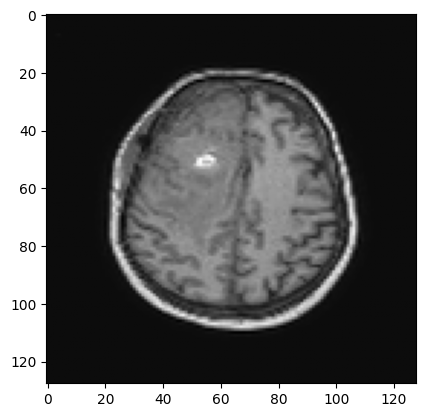

(8, 128, 128)
Plage des valeurs des images d'entrée (bruitées) : 0.0 - 1.000000041637677
torch.Size([8, 1, 128, 128])


In [49]:
# tester avec Pelvis pour un model entrainer avec des cerveau
#Indices correspondant au seed de mes datasets
indices=[102, 30, 135, 79, 6, 150, 109, 145]

data = np.load("Data/images_brain_128.npy")
bigy_test=data[indices]

print(bigy_test.shape)
print("Mean:", bigy_test.mean().item())
print(f"le min et le max {bigy_test.min()} -{bigy_test.max()}")
print(bigy_test[4,32,:])
# Affichage d’une image
plt.imshow(bigy_test[4,:,:], cmap="gray")
plt.show()

images_test_normalized = list(bigy_test)

bigy_test = np.stack(images_test_normalized) #Empiler un tableau nunpy
print(bigy_test.shape)
print(f"Plage des valeurs des images d'entrée (bruitées) : {bigy_test.min()} - {bigy_test.max()}")

images_test_normalized_propre=np.array(images_test_normalized)
tensor_images_test_normalized_propre= torch.from_numpy(images_test_normalized_propre)
tensor_images_test_normalized_propre = tensor_images_test_normalized_propre.unsqueeze(1)
print(tensor_images_test_normalized_propre.shape)





Application des masks et de Fourier pour les images Test que je veux tester

pourcentage raidial 14.337158
pourcentage cartésien 25.78125
F_shifted.shape: torch.Size([8, 2, 128, 128])
Plage des valeurs des images d'entrée (bruitées) : 0.0 - 1.0
<class 'torch.Tensor'>
F_shifted.shape: torch.Size([8, 2, 128, 128])
Plage des valeurs des images d'entrée (bruitées) : -1326.8673096783746 - 4005.335164505871


Text(0.5, 1.0, 'tensor_images_test_normalized_propre ')

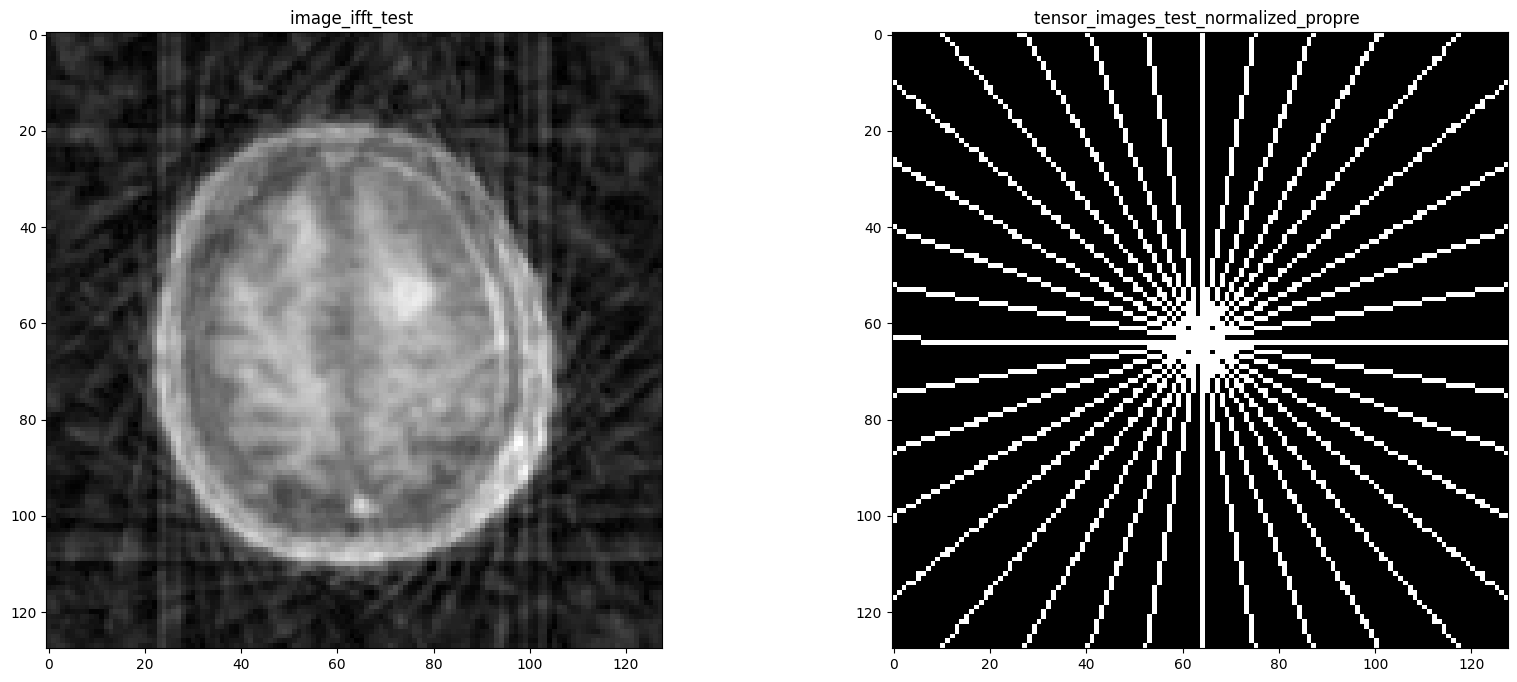

In [43]:
#Modele

import random

F_shifted_mask_test_images = []  # Liste pour stocker les F_shifted de chaque image
F_shifted_mask_test_with_images = [] 

rotation = 10

for image in(images_test_normalized):

    rot=0
    
    FT1_test = fft2(image)
    F_shifted_test = fftshift(FT1_test)

    rows, cols = F_shifted_test.shape
    crow, ccol = rows // 2, cols // 2

    # Masque radiale
    mask0_test = np.zeros((rows, cols), dtype=np.float32)
    for angle_deg in np.arange(0, 180, rotation):  
        angle_rad = np.deg2rad(angle_deg)
        dx = np.cos(angle_rad)
        dy = np.sin(angle_rad)

        for r in range(-max(rows, cols), max(rows, cols)):
            x = int(crow + r * dx)
            y = int(ccol + r * dy)
            
            if 0 <= x < rows and 0 <= y < cols:
                mask0_test[x, y] = 1

    #Masque cartésien
    mask1_test = np.zeros((rows, cols), dtype=np.float32)
    for x in range(0,rows,1):
        # if (crow - 5 < x < crow + 5):
        #     mask1_test[x, :] = 1
        # elif (crow - 13 < x < crow - 10):
        #     mask1_test[x, :] = 1
        # elif (crow + 10 < x < crow + 13):
        #     mask1_test[x, :] = 1    
        # elif (crow + 20 < x < crow + 22):
        #     mask1_test[x, :] = 1    
        # elif (crow - 23 < x < crow - 20):
        #     mask1_test[x, :] = 1
        if (crow - 7 < x < crow + 7):
            mask1_test[x, :] = 1
        elif (crow - 15 < x < crow - 10):
            mask1_test[x, :] = 1
        elif (crow + 10 < x < crow + 15):
            mask1_test[x, :] = 1    
        elif (crow + 20 < x < crow + 25):
            mask1_test[x, :] = 1    
        elif (crow - 25 < x < crow - 20):
            mask1_test[x, :] = 1
        elif (crow + 30 < x < crow + 33):
            mask1_test[x, :] = 1    
        elif (crow - 33 < x < crow - 30):
            mask1_test[x, :] = 1
        # if (crow - 15 < x < crow + 15):
        #     mask1_test[x, :] = 1   
        # elif (crow + 18 < x < crow + 25):
        #     mask1_test[x, :] = 1    
        # elif (crow - 25 < x < crow - 18):
        #     mask1_test[x, :] = 1
        # elif (crow + 30 < x < crow + 35):
        #     mask1_test[x, :] = 1    
        # elif (crow - 35 < x < crow - 30):
        #     mask1_test[x, :] = 1
        # elif (crow + 40 < x < crow + 45):
        #     mask1_test[x, :] = 1    
        # elif (crow - 45 < x < crow - 40):
        #     mask1_test[x, :] = 1
            
    # Appliquer le masque avec K_space
    F_shifted_mask_test=mask0_test #* F_shifted 
    F_shifted_mask1_test=F_shifted_test * mask0_test
    #Partie réel et imaginaire
    #real_part = np.real(F_shifted_mask)
    #imag_part = np.imag(F_shifted_mask)
    real_part_test = F_shifted_mask_test
    imag_part_test = F_shifted_mask_test

    real_part1_test = np.real(F_shifted_mask1_test)
    imag_part1_test = np.imag(F_shifted_mask1_test)
    F_masked_complex_test = np.stack((real_part_test, imag_part_test), axis=-1)
    F_masked_complex1_test = np.stack((real_part1_test, imag_part1_test), axis=-1)
    # magnitude_spectrum = np.abs(F_shifted_mask)
    F_shifted_mask_test_images.append(F_masked_complex_test)
    F_shifted_mask_test_with_images.append(F_masked_complex1_test)

pourcentage=np.sum(mask0_test)/(rows*cols)*100
print("pourcentage raidial",pourcentage)

pourcentage1=np.sum(mask1_test)/(rows*cols)*100
print("pourcentage cartésien",pourcentage1)
    

# MASQUE 2 CANAUX réel et phase
F_mask_test= np.array(F_shifted_mask_test_images)
F_mask_test = np.transpose(F_mask_test, (0, 3, 1, 2))
tensor_F_mask_test = torch.from_numpy(F_mask_test)
print(f"F_shifted.shape: {tensor_F_mask_test.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_F_mask_test.min()} - {tensor_F_mask_test.max()}")


F_mask_test_image= np.array(F_shifted_mask_test_with_images)
F_mask_test_image = np.transpose(F_mask_test_image, (0, 3, 1, 2))
tensor_F_mask_test_image = torch.from_numpy(F_mask_test_image)
print(type(tensor_F_mask_test_image))
print(f"F_shifted.shape: {tensor_F_mask_test_image.shape}") 
print(f"Plage des valeurs des images d'entrée (bruitées) : {tensor_F_mask_test_image.min()} - {tensor_F_mask_test_image.max()}")


real1_test=tensor_F_mask_test_image[0,0,:,:]
imag1_test=tensor_F_mask_test_image[0,1,:,:]
image_ifft_test=torch.abs(torch.fft.ifft2(torch.fft.ifftshift(real1_test + imag1_test*1j)))

plt.figure(figsize=(20,8))
# plt.subplot(1, 2, 1)
# plt.imshow(tensor_images_test_normalized_propre[0,0,:,:], cmap="gray")
# plt.title("tensor_images_test_normalized_propre ")
plt.subplot(1, 2, 1)
plt.imshow(image_ifft_test, cmap="gray")
plt.title("image_ifft_test ")
plt.subplot(1, 2, 2)
plt.imshow(tensor_F_mask_test[0,1,:,:], cmap="gray")
plt.title("tensor_images_test_normalized_propre ")

Inférence :
- Tester avec les images enregistrer dans TestLoader
- Tester avec des images à part

Changer la valeur de i pour afficher les différentes images
Calcul la moyenne et l'écart type de toutes les images test

False
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


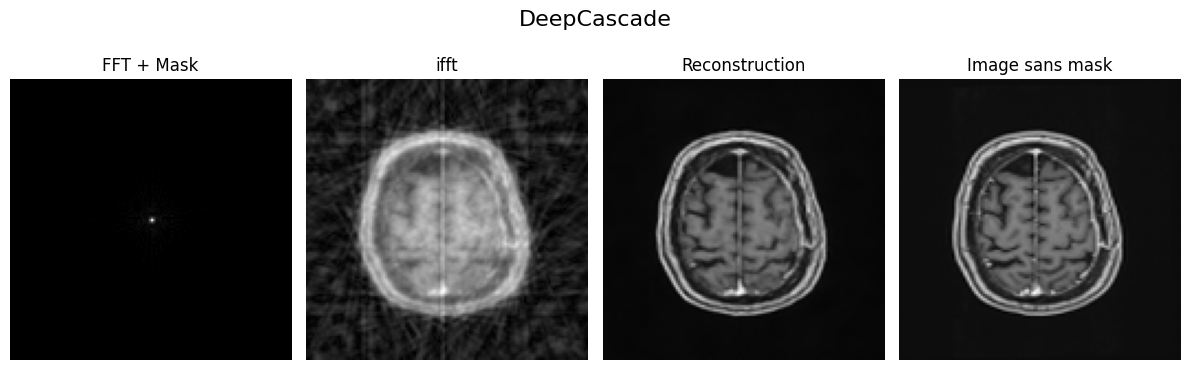

 PSNR sur ifft : 16.65 dB
 PSNR sur modèle: 29.91 dB
 PSNR sur ifft : 15.14 dB
 PSNR sur modèle: 28.15 dB
 PSNR sur ifft : 19.98 dB
 PSNR sur modèle: 29.91 dB
 PSNR sur ifft : 15.33 dB
 PSNR sur modèle: 28.82 dB
 PSNR sur ifft : 14.75 dB
 PSNR sur modèle: 27.42 dB
 PSNR sur ifft : 15.05 dB
 PSNR sur modèle: 27.19 dB
 PSNR sur ifft : 16.41 dB
 PSNR sur modèle: 27.95 dB
 PSNR sur ifft : 21.55 dB
 PSNR sur modèle: 28.80 dB
 PSNR sur ifft : 15.82 dB
 PSNR sur modèle: 26.49 dB
 PSNR sur ifft : 13.81 dB
 PSNR sur modèle: 26.88 dB
 PSNR sur ifft : 16.57 dB
 PSNR sur modèle: 26.13 dB
 PSNR sur ifft : 17.50 dB
 PSNR sur modèle: 24.79 dB
 PSNR sur ifft : 14.85 dB
 PSNR sur modèle: 28.29 dB
 PSNR sur ifft : 19.67 dB
 PSNR sur modèle: 29.07 dB
 PSNR sur ifft : 17.08 dB
 PSNR sur modèle: 28.82 dB
 PSNR sur ifft : 16.75 dB
 PSNR sur modèle: 27.51 dB
 PSNR sur ifft : 15.17 dB
 PSNR sur modèle: 27.14 dB
 PSNR sur ifft : 16.56 dB
 PSNR sur modèle: 28.62 dB
 Entrée -> 16.59 dB
 Sortie -> 27.88 dB
 ecart

In [50]:
#from skimage.metrics import structural_similarity as ssim
#import piq

# 1. Recréer le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model = DeepCascade().to(device)  # même architecture qu'à l'entraînement

moyenne_PSNR_seed_entre=[]
moyenne_PSNR_seed_sortie=[]
moyenne_ecart_type_seed_entre=[]
moyenne_ecart_type_seed_sortie=[]

# 2. Charger les poids
path_model = path_folder + f"/DeepCascade/DeepCascade_image_brain_128_seed_1.pth"
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))
model.eval()

#Tester avec images cerveau/pelvis
input_imgs_liste=[]
input_masks_liste=[]
target_imgs_liste=[]    

with torch.no_grad(): #Désactive les gradients car pas de back propagation
    #input_imgs, input_mask, target_imgs = next(iter(test_loader))
    for input_imgs, input_mask, target_imgs in test_loader:
        input_imgs = input_imgs.to(device).float()
        input_mask = input_mask.to(device).float()
        target_imgs = target_imgs.to(device).float()

        input_imgs_liste.append(input_imgs)
        input_masks_liste.append(input_mask)
        target_imgs_liste.append(target_imgs)

        input_imgs = torch.cat(input_imgs_liste, dim=0)
        input_mask = torch.cat(input_masks_liste, dim=0)
        target_imgs = torch.cat(target_imgs_liste, dim=0)

    # real1_test=input_imgs[0,0,:,:]
    # imag1_test=input_imgs[0,1,:,:]
    # image_ifft_test=torch.abs(torch.fft.ifft2(torch.fft.ifftshift(real1_test + imag1_test*1j)))

    # plt.figure(figsize=(20,8))
    # plt.subplot(1, 3, 1)
    # plt.imshow(image_ifft_test, cmap="gray")
    # plt.title("image_ifft_test ")
    # plt.subplot(1, 3, 2)
    # plt.imshow(input_mask[0,0,:,:], cmap="gray")
    # plt.title("input_mask ")
    # plt.subplot(1, 3, 3)
    # plt.imshow(target_imgs[0,0,:,:], cmap="gray")
    # plt.title("target_imgs ")

    # Tester avec des images à part

    # input_imgs = tensor_F_mask_test_image.to(device).float()
    # input_mask = tensor_F_mask_test.to(device).float()
    # target_imgs = tensor_images_test_normalized_propre.to(device).float()
    
    print(type(input_imgs))
    print(type(input_mask))
    print(type(target_imgs))
    # [N,W,H,2]

    reconstructed = model(input_imgs,input_mask) 
    #print(target_imgs.shape)

    # Complex [N,W,H]
    modelOutput=reconstructed[:,0,:,:] + reconstructed[:,1,:,:] *1j
    #print("Sortie du modele", modelOutput.shape)

    ModelOuputReel=torch.abs(modelOutput)

    # Affichage + Métriques que les 8 images
    index=input_imgs.shape[0]
    i = 0
    
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    #print(input_imgs[i].shape)
    real1=input_imgs[i,0,:,:]*input_mask[i,0,:,:]
    imag1=input_imgs[i,1,:,:]*input_mask[i,1,:,:]

    
    amplitude = torch.sqrt(real1**2 + imag1**2)
    image_ifft = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(real1 + imag1*1j)))
    #magnitude_spectrum=torch.log(amplitude + 1)

    fig.suptitle(f"DeepCascade", fontsize=16)

    axs[0].imshow(amplitude.squeeze().cpu(), cmap='gray')
    axs[0].set_title(f"FFT + Mask")
    axs[1].imshow(image_ifft.squeeze().cpu(), cmap='gray')
    axs[1].set_title(f"ifft")
    axs[2].imshow(ModelOuputReel[i].squeeze().cpu(), cmap='gray')
    axs[2].set_title(f"Reconstruction")
    axs[3].imshow(target_imgs[i].squeeze().cpu(), cmap='gray')
    axs[3].set_title(f"Image sans mask")

    test_ifft = (image_ifft- torch.min(image_ifft))/(torch.max(image_ifft)-torch.min(image_ifft))
    #print(torch.min(test_ifft))
    #print(torch.max(test_ifft))
    
    mse1 = torch.mean((test_ifft - target_imgs[i]) ** 2)
    psnr_value1 = 10 * torch.log10(1.0 / mse1)
    #print(input_imgs.min())
    #print(input_imgs.max())
    #print(f" PSNR sur l'image d'entrée : {psnr_value1:.2f} dB")  

    
    test_modele = (ModelOuputReel[i] - torch.min(ModelOuputReel[i]))/(torch.max(ModelOuputReel[i])-torch.min(ModelOuputReel[i]))
    #print(torch.min(test_modele))
    #print(torch.max(test_modele))
    
    # Calculer la MSE (Mean Squared Error)
    mse2 = torch.mean((test_modele - target_imgs[i])** 2)
    psnr_value2 = 10 * torch.log10(1.0**2 / mse2)
    #print(f" PSNR sur l'image de sortie du modèle: {psnr_value2:.2f} dB")
    
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    psnr_somme1=0
    psnr_somme2=0

    #image ifft
    liste_psnr_values1 = []
    #image reconstruite
    liste_psnr_values2 = []

    #liste_ssim_values1 = []
    #image reconstruite
    #liste_ssim_values2 = []

    for i in range (index):
        real = input_imgs[i, 0, :, :]
        imag = input_imgs[i, 1, :, :]
        complex_kspace = real + 1j * imag

        # Reconstruction par ifft
        image_ifft = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(complex_kspace)))

        # Normalisation individuelle
        test1_ifft = (image_ifft - torch.min(image_ifft)) / (torch.max(image_ifft) - torch.min(image_ifft))

        # Calculer la MSE/PSNR (Mean Squared Error)
        mse1 = torch.mean((target_imgs[i] - test1_ifft) ** 2)
        psnr_value1 = 10 * torch.log10(1.0 **2/ mse1)
        liste_psnr_values1.append(psnr_value1)
        print(f" PSNR sur ifft : {psnr_value1:.2f} dB")   
        
        # Complex [N,W,H]
        modelOutput=reconstructed[i,0,:,:] + reconstructed[i,1,:,:] *1j
        #print("Sortie du modele", modelOutput.shape)

        ModelOuputReel=torch.abs(modelOutput)

        test1_modele = (ModelOuputReel - torch.min(ModelOuputReel))/(torch.max(ModelOuputReel)-torch.min(ModelOuputReel))

        # Calculer la MSE/PSNR (Mean Squared Error)
        mse2 = torch.mean((target_imgs[i] - test1_modele)** 2)
        psnr_value2 = 10 * torch.log10(1.0**2 / mse2)
        liste_psnr_values2.append(psnr_value2)
        print(f" PSNR sur modèle: {psnr_value2:.2f} dB")    
    
    # Conversion en tenseur pour calculs statistiques
    psnr_values_input = torch.tensor(liste_psnr_values1)
    psnr_values_output = torch.tensor(liste_psnr_values2)

    #Moyenne PSNR
    PNSR_entre=torch.mean(psnr_values_input)
    PSNR_sortie=torch.mean(psnr_values_output)

    #Ecart_type PSNR
    ecart_type_entre=torch.std(psnr_values_input)
    ecart_type_sortie=torch.std(psnr_values_output)

    print(f" Entrée -> {PNSR_entre:.2f} dB")    
    moyenne_PSNR_seed_entre.append(PNSR_entre)   
    print(f" Sortie -> {PSNR_sortie:.2f} dB") 
    moyenne_PSNR_seed_sortie.append(PSNR_sortie)   
    print(f" ecart-type Entrée -> {ecart_type_entre:.2f} dB") 
    moyenne_ecart_type_seed_entre.append(ecart_type_entre)     
    print(f" ecart-type Sortie -> {ecart_type_sortie:.2f} dB")
    moyenne_ecart_type_seed_sortie.append(ecart_type_sortie) 



Utiliser pour afficher la moyenne des 5 modèles pour la crosss validation et l'écart-type

In [45]:
# Validation croisée
# Entree
moyenne_PSNR_entree=0
for m in moyenne_PSNR_seed_entre:
    moyenne_PSNR_entree+=m
    
print(f"Moyenne_PSNR_entree: {moyenne_PSNR_entree/5}")
F_moyenne_PSNR_seed_entree=torch.tensor(moyenne_PSNR_seed_entre)
ecart_type_entre_PSNR_entree=torch.std(F_moyenne_PSNR_seed_entree)
print(f"Ecart-type: {ecart_type_entre_PSNR_entree}")

# Sortie
moyenne_PSNR_sortie=0
for m in moyenne_PSNR_seed_sortie:
    #print(m)
    moyenne_PSNR_sortie+=m
    
print(f"Moyenne_PSNR_sortie: {moyenne_PSNR_sortie/5}")
F_moyenne_PSNR_seed_sortie=torch.tensor(moyenne_PSNR_seed_sortie)
ecart_type_entre_PSNR_sortie=torch.std(F_moyenne_PSNR_seed_sortie)
print(f"Ecart-type: {ecart_type_entre_PSNR_sortie}")


Moyenne_PSNR_entree: 3.318406581878662
Ecart-type: nan
Moyenne_PSNR_sortie: 5.576538562774658
Ecart-type: nan


C:\Users\rapha\AppData\Local\Temp\ipykernel_28588\2321282838.py:9: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  ecart_type_entre_PSNR_entree=torch.std(F_moyenne_PSNR_seed_entree)
C:\Users\rapha\AppData\Local\Temp\ipykernel_28588\2321282838.py:20: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  ecart_type_entre_PSNR_sortie=torch.std(F_moyenne_PSNR_seed_sortie)
